<a href="https://colab.research.google.com/github/caitlinkermen/Unit_1_Build_Week/blob/main/Unit_1_Build_Week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Question

Of the available Washington Realestate within a reasonable commute to Seattle what property qualities have the largest affect on Affordability for those who work and live in the same county and Seattle workers who live in another county.

Research Question components
- Zipcode data 
- MLS (Multiple Listing Service) data
- Limited to properties that are livable for a family

Research Sources 
- Redfin.com
- https://www.zipcodestogo.com/Washington/
- https://smartasset.com/taxes/washington-property-tax-calculator
- https://data.ers.usda.gov/reports.aspx?ID=17828

# Setup all libraries needed to run this code

In [2]:
import pandas as pd
import numpy as np
import statistics
import scipy as sp
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import t
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
#all imported librarys used will be listed here.

# Load All Data

In [3]:
#For the smaller csv files it was easier to rename the columns at the same time as loading the data
Zip_Codes_Counties_Within_Commutable_Distance_url = "https://raw.githubusercontent.com/caitlinkermen/Unit_1_Build_Week/main/Zip_Codes_Counties_Within_Commutable_Distance.csv"
Zip_Codes_Counties_Within_Commutable_Distance = pd.read_csv(Zip_Codes_Counties_Within_Commutable_Distance_url)
Zip_Codes_Counties_Within_Commutable_Distance.columns = ["Zipcode","City","County"]

zipcode_property_tax_rate_url = "https://raw.githubusercontent.com/caitlinkermen/Unit_1_Build_Week/main/Zip_Code_Tax_Rate.csv"
zipcode_property_tax_rate = pd.read_csv(zipcode_property_tax_rate_url)
zipcode_property_tax_rate.columns = ["County","Property_Tax_Rate"]

mean_income_csv_url = "https://raw.githubusercontent.com/caitlinkermen/Unit_1_Build_Week/main/UnemploymentReport_and_Mean_Income.csv"
mean_income_csv = pd.read_csv(mean_income_csv_url)
mean_income_csv.columns = ['FIPS ', 'Name', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', 'Mean Household Income (2018)',
       '% of State Mean HH Income']

In [4]:
#MLS Data for all counties within a reasonable commute to seattle
all_counties_url = "https://raw.githubusercontent.com/caitlinkermen/Unit_1_Build_Week/main/All_Counties_MLS%20-%20Sheet1.csv"
all_counties = pd.read_csv(all_counties_url)

#Two weeks after loading the first datasets I decided to get an updated MLS 
all_counties_new_url = "https://raw.githubusercontent.com/caitlinkermen/Unit_1_Build_Week/main/All_Counties.csv"
all_counties_new = pd.read_csv(all_counties_new_url)

#I got an updated MLS again
all_counties_newer_url = "https://raw.githubusercontent.com/caitlinkermen/Unit_1_Build_Week/main/ALL_COUNTIES%20-%20redfin_2020-10-16-18-22-05.csv"
all_counties_newer = pd.read_csv(all_counties_newer_url)

#I also loaded the sold data for the past 5 years I may or may not use this.
all_counties_sold_5yr_url = "https://raw.githubusercontent.com/caitlinkermen/Unit_1_Build_Week/main/MLS_All_Counties_Sold_5Yr.csv"
all_counties_sold_5yr = pd.read_csv(all_counties_sold_5yr_url)

# Check that they loaded properly

In [5]:
#Zip_Codes_Counties_Within_Commutable_Distance.head(2)

In [6]:
#mean_income_csv.head(2)

In [7]:
#all_counties.head(2)

In [8]:
#all_counties_new.head(2)

In [9]:
#all_counties_newer.head(2)

In [10]:
#all_counties_sold_5yr.head(2)

# Clean the Data

To clean the data I will need to:
- combine datasets as needed
  - using filters 
  - by matching column values
- ensure there are no duplicates
  - specific datapoints should not have duplicate values
- Standardize column labling
- Drop Columns as needed
- Drop rows with Nan values in specific columns
- Organize Column order
- Change float to int on specific columns as needed
- Set Year Built column to date

Zip Code Data

In [11]:
#I used the Zip_Codes_Counties_Within_Commutable_Distance dataframe 
#to limit the zipcode_property_tax_rate dataframe to only include 
#Counties that are within a reasonable commute to Seattle
property_tax_condition = zipcode_property_tax_rate["County"].isin(Zip_Codes_Counties_Within_Commutable_Distance["County"])
property_tax_subset = zipcode_property_tax_rate[property_tax_condition]
print(property_tax_subset.shape)
print(property_tax_subset)

(7, 2)
       County  Property_Tax_Rate
14     Island             0.0084
16       King             0.0095
17     Kitsap             0.0101
26     Pierce             0.0121
28     Skagit             0.0101
30  Snohomish             0.0100
36    Whatcom             0.0087


In [12]:
mean_income_csv = mean_income_csv.drop(['FIPS ', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '% of State Mean HH Income'],axis = 1)
mean_income_csv = mean_income_csv.drop(0)
mean_income_csv = mean_income_csv.drop(40)
mean_income_csv = mean_income_csv.drop(41)

In [13]:
mean_income_csv.columns = ['County', 'Mean_Income']

In [14]:
#clean up strings
def clean_str(dirty_str):
  if isinstance(dirty_str, str):
    return dirty_str.replace(" County, WA","").strip()
  else:
    return dirty_str

In [15]:
mean_income_csv["County"] = mean_income_csv["County"].apply(clean_str)

In [16]:
#clean up strings
def remove_dollar_comma(dirty_str):
  if isinstance(dirty_str, str):
    return dirty_str.replace("$","").replace(",","").strip()
  else:
    return dirty_str

In [17]:
mean_income_csv["Mean_Income"] = mean_income_csv["Mean_Income"].apply(remove_dollar_comma)
mean_income_csv["Mean_Income"] = mean_income_csv["Mean_Income"].astype(int)

In [18]:
#I used the Zip_Codes_Counties_Within_Commutable_Distance dataframe 
#to limit the zipcode_mean_income dataframe to only include 
#Zipcodes that are within a reasonable commute to Seattle
mean_income_condition = mean_income_csv["County"].isin(Zip_Codes_Counties_Within_Commutable_Distance["County"])
mean_income_subset = mean_income_csv[mean_income_condition]
print(mean_income_subset.shape)
print(mean_income_subset.head())

(7, 2)
    County  Mean_Income
15  Island        65987
17    King        94822
18  Kitsap        76530
27  Pierce        75022
29  Skagit        70955


In [19]:
mean_income_subset.head(3)

,County,Mean_Income
15,Island,65987
17,King,94822
18,Kitsap,76530


In [20]:
#this may not have been the best way to do this but I needed to round 
#the mean income down to the nearest int for easier calculations later.
mean_income_subset["Mean_Income"] = mean_income_subset["Mean_Income"].astype(int)
mean_income_subset.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,County,Mean_Income
15,Island,65987
17,King,94822
18,Kitsap,76530
27,Pierce,75022
29,Skagit,70955


In [21]:
#Merging the dataframes
commute_and_mean_income = pd.merge(Zip_Codes_Counties_Within_Commutable_Distance,mean_income_subset,on = "County", how = "inner")
commute_and_mean_income.head()

,Zipcode,City,County,Mean_Income
0,98282,Camano Island,Island,65987
1,98236,Clinton,Island,65987
2,98239,Coupeville,Island,65987
3,98249,Freeland,Island,65987
4,98253,Greenbank,Island,65987


In [22]:
#Merging the dataframes 
zipcode_data = pd.merge(commute_and_mean_income,property_tax_subset,on = "County", how = "inner")
zipcode_data.head()

,Zipcode,City,County,Mean_Income,Property_Tax_Rate
0,98282,Camano Island,Island,65987,0.0084
1,98236,Clinton,Island,65987,0.0084
2,98239,Coupeville,Island,65987,0.0084
3,98249,Freeland,Island,65987,0.0084
4,98253,Greenbank,Island,65987,0.0084


MLS Data

In [23]:
#Combining the data for the previous MLS download and the more current one. 
all_counties_mls_list = [all_counties,all_counties_new,all_counties_newer,all_counties_sold_5yr]
#Combining all the data
all_counties_mls = pd.concat(all_counties_mls_list)
print(all_counties_mls.shape)

(4277, 27)


In [24]:
all_counties_mls["PROPERTY TYPE"].unique()

array(['Single Family Residential', 'Vacant Land', 'Condo/Co-op',
       'Mobile/Manufactured Home', 'Multi-Family (2-4 Unit)', 'Ranch',
       'Moorage', 'Townhouse', 'Multi-Family (5+ Unit)', 'Parking',
       'Other', 'Unknown'], dtype=object)

I do not want these properties to be included:

'Vacant Land', 'Ranch', 'Moorage', 'Multi-Family (5+ Unit)', 'Parking', 'Other', 'Unknown'



In [25]:
property_condition = all_counties_mls["PROPERTY TYPE"].isin(['Single Family Residential', 'Condo/Co-op',
       'Mobile/Manufactured Home', 'Townhouse','Multi-Family (2-4 Unit)'])
all_counties_mls = all_counties_mls[property_condition]
print(all_counties_mls.shape)
all_counties_mls.head(2)

(3426, 27)


,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,STATUS,NEXT OPEN HOUSE START TIME,NEXT OPEN HOUSE END TIME,URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,MLS Listing,NaN,Single Family Residential,520 E Highland Ave,Mount Vernon,WA,98273.0,380000,3.0,2.25,Mount Vernon,1540.0,4792.0,1983.0,6.0,247.0,NaN,Active,NaN,NaN,http://www.redfin.com/WA/Mt-Vernon/520-E-Highl...,NWMLS,1666770.0,N,Y,48.424872,-122.329990
1,MLS Listing,NaN,Single Family Residential,4601 Beaver Pond Dr S,Mount Vernon,WA,98274.0,908000,5.0,4.00,Mount Vernon,5392.0,13939.0,2008.0,91.0,168.0,55.0,Active,NaN,NaN,http://www.redfin.com/WA/Mt-Vernon/4601-Beaver...,NWMLS,1622974.0,N,Y,48.405891,-122.279209


I must delete any duplicate entries. They may be found by looking for double entries in the Address column and the MLS# column

In [26]:
#look for duplicate data
any(all_counties_mls["MLS#"].duplicated())
any(all_counties_mls["ADDRESS"].duplicated())

True

In [27]:
#Drop any duplicates 
all_counties_mls = all_counties_mls.drop_duplicates("MLS#")
all_counties_mls =all_counties_mls.drop_duplicates("ADDRESS")
print(all_counties_mls.shape)

(2764, 27)


In [28]:
#Look for null values in MLS# column
any(all_counties_mls["MLS#"].isnull())

True

In [29]:
all_counties_mls = all_counties_mls.dropna(subset= ["MLS#"])

At this point I want to clean up the MLS data column headers

In [30]:
 #Changing the column names to be more concise and any spaces are replaced with _
 all_counties_mls.columns = ['Sale_Type', 'Sold_Date', 'Property_Type', 'Address', 'City',
       'STATE_OR_PROVINCE', 'Zipcode', 'Price', 'Beds', 'Baths',
       'LOCATION', 'Square_feet', 'Lot_Size', 'Year_Built', 'DAYS_ON MARKET',
       '$/Square_feet', 'HOA/MONTH', 'STATUS', 'NEXT_OPEN_HOUSE_START_TIME',
       'NEXT_OPEN_HOUSE_END TIME','URL',
       'SOURCE', 'MLS#', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE']

In [31]:
#drop unnessary columns
mls = all_counties_mls.drop(['STATE_OR_PROVINCE',
       'LOCATION', 'DAYS_ON MARKET',
       'HOA/MONTH', 'STATUS', 'NEXT_OPEN_HOUSE_START_TIME',
       'NEXT_OPEN_HOUSE_END TIME','URL',
       'SOURCE', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE'],axis = 1)

In [32]:
#mls.head(2)

# Combine the Datasets

I combined the zipcode dataset and the mls dataset using the zipcode column.

In [33]:
mls_and_zipcode_data = pd.merge(mls,zipcode_data,on = "Zipcode", how = "inner")
mls_and_zipcode_data.head(2)

,Sale_Type,Sold_Date,Property_Type,Address,City_x,Zipcode,Price,Beds,Baths,Square_feet,Lot_Size,Year_Built,$/Square_feet,MLS#,City_y,County,Mean_Income,Property_Tax_Rate
0,MLS Listing,NaN,Single Family Residential,520 E Highland Ave,Mount Vernon,98273.0,380000,3.0,2.25,1540.0,4792.0,1983.0,247.0,1666770.0,Mount Vernon,Skagit,70955,0.0101
1,MLS Listing,NaN,Single Family Residential,2222 E Fulton St,Mount Vernon,98273.0,300000,2.0,1.00,916.0,4972.0,1982.0,328.0,1670882.0,Mount Vernon,Skagit,70955,0.0101


In [34]:
#I noticed that the merge created two City columns. 
#I decided to drop City_y and Rename City_x to City
mls_and_zipcode_data = mls_and_zipcode_data.drop(["City_y"],axis=1)

In [35]:
#To get the current column name list so I can rename City_x to City
print(mls_and_zipcode_data.columns)

Index(['Sale_Type', 'Sold_Date', 'Property_Type', 'Address', 'City_x',
       'Zipcode', 'Price', 'Beds', 'Baths', 'Square_feet', 'Lot_Size',
       'Year_Built', '$/Square_feet', 'MLS#', 'County', 'Mean_Income',
       'Property_Tax_Rate'],
      dtype='object')


In [36]:
#Re name column City_x to City
mls_and_zipcode_data.columns = ['Sale_Type', 'Sold_Date', 'Property_Type', 'Address', 'City',
       'Zipcode', 'Price', 'Beds', 'Baths', 'Square_Feet', 'Lot_Size',
       'Year_Built', '$/Square_Feet', 'MLS#', 'County', 'Mean_Income',
       'Property_Tax_Rate']
#mls_and_zipcode_data.head()
#print(mls_and_zipcode_data.dtypes)

In [37]:
#These columns are critical to my analysis so I must eliminate any data where these fields are null
valid_data_only = mls_and_zipcode_data.dropna(subset=['Beds', 'Baths', 'Square_Feet', 'Lot_Size', 'Year_Built', '$/Square_Feet'])
print(valid_data_only.shape)
valid_data_only.head(2)

(2332, 17)


,Sale_Type,Sold_Date,Property_Type,Address,City,Zipcode,Price,Beds,Baths,Square_Feet,Lot_Size,Year_Built,$/Square_Feet,MLS#,County,Mean_Income,Property_Tax_Rate
0,MLS Listing,NaN,Single Family Residential,520 E Highland Ave,Mount Vernon,98273.0,380000,3.0,2.25,1540.0,4792.0,1983.0,247.0,1666770.0,Skagit,70955,0.0101
1,MLS Listing,NaN,Single Family Residential,2222 E Fulton St,Mount Vernon,98273.0,300000,2.0,1.00,916.0,4972.0,1982.0,328.0,1670882.0,Skagit,70955,0.0101


I want to reorganize the column order to make it more readable

In [38]:
reordered_data = valid_data_only[
       ['Sale_Type','Sold_Date','MLS#','County','City','Address','Zipcode','Lot_Size','Square_Feet','$/Square_Feet','Beds','Baths','Year_Built','Price',
       'Property_Tax_Rate','Mean_Income']]
reordered_data.head(2)

,Sale_Type,Sold_Date,MLS#,County,City,Address,Zipcode,Lot_Size,Square_Feet,$/Square_Feet,Beds,Baths,Year_Built,Price,Property_Tax_Rate,Mean_Income
0,MLS Listing,NaN,1666770.0,Skagit,Mount Vernon,520 E Highland Ave,98273.0,4792.0,1540.0,247.0,3.0,2.25,1983.0,380000,0.0101,70955
1,MLS Listing,NaN,1670882.0,Skagit,Mount Vernon,2222 E Fulton St,98273.0,4972.0,916.0,328.0,2.0,1.00,1982.0,300000,0.0101,70955


In [39]:
#There are entries in the Beds column that show as 0. These need to be removed. 
for col in reordered_data[['Beds', 'Baths']]:
  print(col)
  print(reordered_data[col].unique())

Beds
[ 3.  2.  4.  1.  5.  6.  0.  9.  8.  7. 11. 14. 12.]
Baths
[ 2.25  1.    2.    2.5   1.75  1.5   3.    0.75  3.25  3.5   4.    3.75
  1.25  2.75  5.5   5.    4.25  5.25  9.    4.5   6.25  4.75 10.5   0.5
  5.75  6.    6.75  7.5   7.  ]


In [40]:
#save a version of the dataframe where the beds column does not equal 0.
reordered_data = reordered_data[reordered_data.Beds != 0.]

#Check that there are no more 0. entries in the Beds column
reordered_data["Beds"].unique()

array([ 3.,  2.,  4.,  1.,  5.,  6.,  9.,  8.,  7., 11., 14., 12.])

In [41]:
display(reordered_data.dtypes)

Sale_Type             object
Sold_Date             object
MLS#                 float64
County                object
City                  object
Address               object
Zipcode              float64
Lot_Size             float64
Square_Feet          float64
$/Square_Feet        float64
Beds                 float64
Baths                float64
Year_Built           float64
Price                  int64
Property_Tax_Rate    float64
Mean_Income            int64
dtype: object

In [42]:
#set Lot_Size, Square_Feet, $/Square_Feet, Beds, Year_Built columns to int
reordered_data = reordered_data.astype({"MLS#":'int',"Zipcode":'int',"Lot_Size":'int',"Square_Feet":'int',"$/Square_Feet":'int',"Beds":'int',"Year_Built":'int'})

In [43]:
#The only floats should be in Baths and Property_Tax_Rate columns
print(reordered_data.dtypes)

Sale_Type             object
Sold_Date             object
MLS#                   int64
County                object
City                  object
Address               object
Zipcode                int64
Lot_Size               int64
Square_Feet            int64
$/Square_Feet          int64
Beds                   int64
Baths                float64
Year_Built             int64
Price                  int64
Property_Tax_Rate    float64
Mean_Income            int64
dtype: object


In [44]:
#set Year_Built to date
reordered_data["Year_Built"] = pd.to_datetime(reordered_data["Year_Built"], infer_datetime_format=True)

reordered_data["Year_Built"] = reordered_data["Year_Built"].dt.year 
reordered_data.head(2)

,Sale_Type,Sold_Date,MLS#,County,City,Address,Zipcode,Lot_Size,Square_Feet,$/Square_Feet,Beds,Baths,Year_Built,Price,Property_Tax_Rate,Mean_Income
0,MLS Listing,NaN,1666770,Skagit,Mount Vernon,520 E Highland Ave,98273,4792,1540,247,3,2.25,1970,380000,0.0101,70955
1,MLS Listing,NaN,1670882,Skagit,Mount Vernon,2222 E Fulton St,98273,4972,916,328,2,1.00,1970,300000,0.0101,70955


In [45]:
#set Sold_Date to date
reordered_data["Sold_Date"] = pd.to_datetime(reordered_data["Sold_Date"], infer_datetime_format=True)

reordered_data["Sold_Date"] = reordered_data["Sold_Date"].dt.year 
reordered_data.head(2)

,Sale_Type,Sold_Date,MLS#,County,City,Address,Zipcode,Lot_Size,Square_Feet,$/Square_Feet,Beds,Baths,Year_Built,Price,Property_Tax_Rate,Mean_Income
0,MLS Listing,NaN,1666770,Skagit,Mount Vernon,520 E Highland Ave,98273,4792,1540,247,3,2.25,1970,380000,0.0101,70955
1,MLS Listing,NaN,1670882,Skagit,Mount Vernon,2222 E Fulton St,98273,4972,916,328,2,1.00,1970,300000,0.0101,70955


# Create Features

In [46]:
#Save a copy in case I need to back-track
feature_creation = reordered_data

In [47]:
#Years from Year_Built
feature_creation["Age"] = 2020-feature_creation["Year_Built"]

In [48]:
#Percentage for home maintenance savings
percentage_conditions = [
(feature_creation["Age"]<=8),
(feature_creation["Age"]>8)&(feature_creation["Age"]<=17),
(feature_creation["Age"]>17)&(feature_creation["Age"]<=26),
(feature_creation["Age"]>26)
]
values = [.01,.02,.03,.04]

feature_creation["%For_Home_Maintenance"] = np.select(percentage_conditions,values)

In [49]:
#Financed Amount (80%)
feature_creation["Financed$"] = (.8*feature_creation["Price"])

In [50]:
feature_creation["Financed$"] = feature_creation["Financed$"].astype(int)

## To calculate the mortgage payment I need to make the follwoing assumptions:

# Consumer data 
- Credit score above 680
- 30-year fixed rate mortgage at 3% interest
- Down payment of 20%

# Cost to own 
- Maintenance cost 1-4% of total home value annually
- Homeowner’s insurance 1% of total home value annually
- PMI insurance is avoided with a 20% down payment
- Property Tax is calculated based on location/zip code

# Mortgage Math
- https://www.mtgprofessor.com/formulas.htm

The following formula is used to calculate the fixed monthly payment (P) required to fully amortize a loan of L dollars over a term of n months at a monthly interest rate of c. 

If the quoted rate is 6%, for example, c is .06/12 or .005.

P = L[c(1 + c)**n]/[(1 + c)**n - 1]

Payment = Financed $[(interest/12)(1+(interest/12))^number of months]/[(1+(interest/12))^number of months-1]

.004216 =[.0025(1 + .0025)**360]/[(1 + .0025)**360 - 1]

In [51]:
#Mortgage Payment
feature_creation["Mortgage"] = round((.004216*feature_creation["Financed$"]),2)

In [52]:
#Total % Cost to own
feature_creation["Total%_Cost_To_Own"] = (feature_creation["Property_Tax_Rate"] + feature_creation["%For_Home_Maintenance"] + .01)

In [53]:
#Total $ Cost to own
feature_creation["Total$_Cost_To_Own"] = round(((feature_creation["Price"]*feature_creation["Total%_Cost_To_Own"])/12)+feature_creation["Mortgage"],2)

As a general rule banks will usually decline a loan application if the cost to own the home is not below 30% of the applicant's income.

In [54]:
#Income required to Afford
feature_creation["Income_Req_To_Afford"] = round((feature_creation["Total$_Cost_To_Own"]*12)*(100/30),2)

In [55]:
#Affordable
feature_creation["Affordable"] = np.where(feature_creation["Mean_Income"]>=feature_creation["Income_Req_To_Afford"],True,False)

In [56]:
#Cost to own % of mean income
feature_creation["Cost_to_Own%of_Mean_Income"] = (feature_creation["Total$_Cost_To_Own"])/(feature_creation["Mean_Income"]/12)

To illustrate how close some of these properties are to being affordable I have added the column %Above_Below_Affordable

In [57]:
#% Above Below Affordable
feature_creation["%Above_Below_Affordable"] = round((feature_creation["Cost_to_Own%of_Mean_Income"] - .30),2)

In [58]:
#check for number of categorical vs numeric columns
cat_cols = feature_creation.columns[feature_creation.dtypes=='object']
num_cols = feature_creation.columns[feature_creation.dtypes!='object']

print(f'{len(cat_cols)} categorical columns')
print(f'{len(num_cols)} numerical columns')

4 categorical columns
22 numerical columns


In [59]:
#I am going to set County and City to categorical values so I want to save a copy with the string values in a new column
feature_creation["County_Name"] = feature_creation["County"]
feature_creation["City_Name"] = feature_creation["City"]

In [60]:
#set County and City to category
feature_creation= feature_creation.astype({"County":'category',"City":'category'})

In [61]:
#set category columns to numerical values 
for col in feature_creation[["County","City"]]:
  feature_creation[col] = feature_creation[col].cat.codes

print(feature_creation.shape)
feature_creation.head(2)

(2327, 28)


,Sale_Type,Sold_Date,MLS#,County,City,Address,Zipcode,Lot_Size,Square_Feet,$/Square_Feet,Beds,Baths,Year_Built,Price,Property_Tax_Rate,Mean_Income,Age,%For_Home_Maintenance,Financed$,Mortgage,Total%_Cost_To_Own,Total$_Cost_To_Own,Income_Req_To_Afford,Affordable,Cost_to_Own%of_Mean_Income,%Above_Below_Affordable,County_Name,City_Name
0,MLS Listing,NaN,1666770,4,80,520 E Highland Ave,98273,4792,1540,247,3,2.25,1970,380000,0.0101,70955,50,0.04,304000,1281.66,0.0601,3184.83,127393.2,False,0.538623,0.24,Skagit,Mount Vernon
1,MLS Listing,NaN,1670882,4,80,2222 E Fulton St,98273,4972,916,328,2,1.00,1970,300000,0.0101,70955,50,0.04,240000,1011.84,0.0601,2514.34,100573.6,False,0.425228,0.13,Skagit,Mount Vernon


In [62]:
#calculate the ratio of bedrooms to bathrooms
feature_creation["Ratio_BedBath"] = feature_creation["Beds"]//feature_creation["Baths"]

In [63]:
#Create subset to only inclued King County 
kingcounty_condition = feature_creation["County_Name"]=="King"
seattle_subset = feature_creation[kingcounty_condition]

In [64]:
#Find the Mean income for the subset
seattle_subset["Mean_Income"].unique()

array([94822])

In [65]:
#set column to mean income for Seattle(King County)
feature_creation["Seattle_Mean_Income"] = 94822

In [66]:
#Seattle_Cost_to_Own%of_Mean_Income
feature_creation["Seattle_Cost_to_Own%of_Mean_Income"] =(feature_creation["Total$_Cost_To_Own"])/(feature_creation["Seattle_Mean_Income"]/12)

In [67]:
#% Above/Below Affordable for Seattle Mean Income
feature_creation["Seattle%AboveBelow_Affordable"] = round((feature_creation["Seattle_Cost_to_Own%of_Mean_Income"] - .30),2)

In [68]:
#Affordable for Seattle Mean Income
feature_creation["Affordable_Seattle_Mean_Income"] = np.where(feature_creation["Seattle_Mean_Income"]>=feature_creation["Income_Req_To_Afford"],True,False)

In [69]:
#feature_creation.head(2)

I need to include only the columns that will be used in hypothesis testing 

I dont need the following columns:
- Sale_Type
- Sold_Date
- Address

In [70]:
#saving a copy in case I need to back-track
cleaned_data = feature_creation[['MLS#', 'County', 'City',
       'Zipcode', 'Lot_Size', 'Square_Feet', '$/Square_Feet', 'Beds', 'Baths',
       'Year_Built', 'Price', 'Property_Tax_Rate', 'Mean_Income', 'Age',
       '%For_Home_Maintenance', 'Financed$', 'Mortgage', 'Total%_Cost_To_Own',
       'Total$_Cost_To_Own', 'Income_Req_To_Afford', 'Affordable',
       'Cost_to_Own%of_Mean_Income', '%Above_Below_Affordable', 'County_Name',
       'City_Name', 'Ratio_BedBath',"Affordable_Seattle_Mean_Income",
       "Seattle%AboveBelow_Affordable"]]

In [71]:
#Reorganizing the column order
cleaned_data = cleaned_data[['MLS#', 'County','County_Name', 'City','City_Name',
       'Zipcode', 'Lot_Size', 'Square_Feet', '$/Square_Feet', 'Beds', 'Baths','Ratio_BedBath',
       'Year_Built', 'Price', 'Property_Tax_Rate', 'Mean_Income', 'Age',
       '%For_Home_Maintenance', 'Financed$', 'Mortgage', 'Total%_Cost_To_Own',
       'Total$_Cost_To_Own', 'Income_Req_To_Afford', 'Affordable',
       'Cost_to_Own%of_Mean_Income', '%Above_Below_Affordable', 
       "Affordable_Seattle_Mean_Income","Seattle%AboveBelow_Affordable"]]

In [72]:
cleaned_data.head(2)

,MLS#,County,County_Name,City,City_Name,Zipcode,Lot_Size,Square_Feet,$/Square_Feet,Beds,Baths,Ratio_BedBath,Year_Built,Price,Property_Tax_Rate,Mean_Income,Age,%For_Home_Maintenance,Financed$,Mortgage,Total%_Cost_To_Own,Total$_Cost_To_Own,Income_Req_To_Afford,Affordable,Cost_to_Own%of_Mean_Income,%Above_Below_Affordable,Affordable_Seattle_Mean_Income,Seattle%AboveBelow_Affordable
0,1666770,4,Skagit,80,Mount Vernon,98273,4792,1540,247,3,2.25,1.0,1970,380000,0.0101,70955,50,0.04,304000,1281.66,0.0601,3184.83,127393.2,False,0.538623,0.24,False,0.10
1,1670882,4,Skagit,80,Mount Vernon,98273,4972,916,328,2,1.00,2.0,1970,300000,0.0101,70955,50,0.04,240000,1011.84,0.0601,2514.34,100573.6,False,0.425228,0.13,False,0.02


# **Hypothesis Testing**

In [73]:
#cleaned_data.describe()

In [74]:
cleaned_data.head(2)

,MLS#,County,County_Name,City,City_Name,Zipcode,Lot_Size,Square_Feet,$/Square_Feet,Beds,Baths,Ratio_BedBath,Year_Built,Price,Property_Tax_Rate,Mean_Income,Age,%For_Home_Maintenance,Financed$,Mortgage,Total%_Cost_To_Own,Total$_Cost_To_Own,Income_Req_To_Afford,Affordable,Cost_to_Own%of_Mean_Income,%Above_Below_Affordable,Affordable_Seattle_Mean_Income,Seattle%AboveBelow_Affordable
0,1666770,4,Skagit,80,Mount Vernon,98273,4792,1540,247,3,2.25,1.0,1970,380000,0.0101,70955,50,0.04,304000,1281.66,0.0601,3184.83,127393.2,False,0.538623,0.24,False,0.10
1,1670882,4,Skagit,80,Mount Vernon,98273,4972,916,328,2,1.00,2.0,1970,300000,0.0101,70955,50,0.04,240000,1011.84,0.0601,2514.34,100573.6,False,0.425228,0.13,False,0.02


In [75]:
hypothesis_county = cleaned_data[["County","County_Name","Beds","Baths","Square_Feet","$/Square_Feet","Price","Affordable","%Above_Below_Affordable","Affordable_Seattle_Mean_Income","Seattle%AboveBelow_Affordable","Mean_Income"]]

County code, name listed north to south

- 6 = Whatcom
- 0 = Island
- 4 = Skagit
- 5 = Snohomish
- 1 = King (Seattle)
- 3 = Pierce
- 2 = Kitsap


In [76]:
whatcom = hypothesis_county.where(hypothesis_county["County"]==6)
whatcom = whatcom.dropna()
island = hypothesis_county.where(hypothesis_county["County"]==0)
island = island.dropna()
skagit = hypothesis_county.where(hypothesis_county["County"]==4)
skagit = skagit.dropna()
snohomish = hypothesis_county.where(hypothesis_county["County"]==5)
snohomish = snohomish.dropna()
king = hypothesis_county.where(hypothesis_county["County"]==1)
king = king.dropna()
pierce = hypothesis_county.where(hypothesis_county["County"]==3)
pierce = pierce.dropna()
kitsap = hypothesis_county.where(hypothesis_county["County"]==2)
kitsap = kitsap.dropna();

## Number of Beds 

**Null Hypothesis**
- The Number of Beds WILL NOT have a statistically signifigant affect on the price or affordability of the property. 

**Alternative Hypothesis**
- The Number of Beds WILL have a statistically signifigant affect on the price or affordability of the property. 

In [77]:
#TTEST
stats.ttest_ind(cleaned_data["Beds"],cleaned_data["Price"],nan_policy="omit")

Ttest_indResult(statistic=-63.88169004480672, pvalue=0.0)

In [78]:
#Testing to see for each county if the # of beds affects property price
print(stats.ttest_ind(whatcom["Beds"],whatcom["Price"],nan_policy="omit"))
print(stats.ttest_ind(island["Beds"],island["Price"],nan_policy="omit"))
print(stats.ttest_ind(skagit["Beds"],skagit["Price"],nan_policy="omit"))
print(stats.ttest_ind(snohomish["Beds"],snohomish["Price"],nan_policy="omit"))
print(stats.ttest_ind(king["Beds"],king["Price"],nan_policy="omit"))
print(stats.ttest_ind(pierce["Beds"],pierce["Price"],nan_policy="omit"))
print(stats.ttest_ind(kitsap["Beds"],kitsap["Price"],nan_policy="omit"))

Ttest_indResult(statistic=-23.810409904663842, pvalue=6.171411227108107e-90)
Ttest_indResult(statistic=-14.75274817365891, pvalue=7.751759659956203e-38)
Ttest_indResult(statistic=-17.48368347286431, pvalue=4.6629194293731935e-49)
Ttest_indResult(statistic=-34.98128005592451, pvalue=8.206380073142853e-156)
Ttest_indResult(statistic=-33.46449205889797, pvalue=2.584454176724414e-162)
Ttest_indResult(statistic=-40.082706703545554, pvalue=1.217073516802573e-189)
Ttest_indResult(statistic=-24.048291861398045, pvalue=2.3542917088728997e-100)


In [79]:
#Testing to see for each county if the # of beds affects affordability
print(stats.ttest_ind(whatcom["Beds"],whatcom["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(island["Beds"],island["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(skagit["Beds"],skagit["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(snohomish["Beds"],snohomish["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(king["Beds"],king["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(pierce["Beds"],pierce["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(kitsap["Beds"],kitsap["%Above_Below_Affordable"],nan_policy="omit"))

Ttest_indResult(statistic=32.82628687840371, pvalue=1.0863320132743358e-138)
Ttest_indResult(statistic=17.179955145498745, pvalue=3.527464473147406e-47)
Ttest_indResult(statistic=27.78723089905933, pvalue=7.366453513661882e-89)
Ttest_indResult(statistic=53.56623892134478, pvalue=8.034286263689271e-250)
Ttest_indResult(statistic=48.635388193698304, pvalue=6.644724577741647e-259)
Ttest_indResult(statistic=48.06614912876036, pvalue=1.260301966067171e-232)
Ttest_indResult(statistic=53.141810493920985, pvalue=6.561833399860562e-288)


In [80]:
bed1 = cleaned_data.where(cleaned_data["Beds"]==1).dropna()
bed2 = cleaned_data.where(cleaned_data["Beds"]==2).dropna()
bed3 = cleaned_data.where(cleaned_data["Beds"]==3).dropna()
bed4 = cleaned_data.where(cleaned_data["Beds"]==4).dropna()
bed5 = cleaned_data.where(cleaned_data["Beds"]==5).dropna()
bed6 = cleaned_data.where(cleaned_data["Beds"]==6).dropna()
bed7 = cleaned_data.where(cleaned_data["Beds"]==7).dropna()
bed8 = cleaned_data.where(cleaned_data["Beds"]==8).dropna()
bed9 = cleaned_data.where(cleaned_data["Beds"]==9).dropna()
bed11 = cleaned_data.where(cleaned_data["Beds"]==11).dropna()
bed12 = cleaned_data.where(cleaned_data["Beds"]==12).dropna()
bed14 = cleaned_data.where(cleaned_data["Beds"]==14).dropna()

In [81]:
bed1["Price"].mean()

339899.08771929826

In [82]:
prices_beds = [
               bed1["Price"].mean(),bed2["Price"].mean(),
               bed3["Price"].mean(),bed4["Price"].mean(),
               bed5["Price"].mean(),bed6["Price"].mean(),
               bed7["Price"].mean(),bed8["Price"].mean(),
               bed9["Price"].mean(),bed11["Price"].mean(),
               bed12["Price"].mean(),bed14["Price"].mean()
]

In [83]:
number_of_beds = cleaned_data["Beds"].unique().tolist()
number_of_beds.sort()

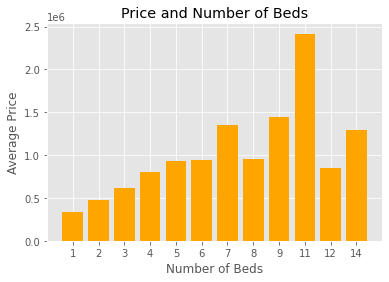

In [84]:
#GRAPH all properties # of Beds vs Price
%matplotlib inline
plt.style.use('ggplot')

x = number_of_beds
y = prices_beds

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='orange')
plt.xlabel("Number of Beds")
plt.ylabel("Average Price")
plt.title("Price and Number of Beds")

plt.xticks(x_pos, x)

plt.show()

In [85]:
affordpercent_beds = [
               bed1["%Above_Below_Affordable"].mean(),bed2["%Above_Below_Affordable"].mean(),
               bed3["%Above_Below_Affordable"].mean(),bed4["%Above_Below_Affordable"].mean(),
               bed5["%Above_Below_Affordable"].mean(),bed6["%Above_Below_Affordable"].mean(),
               bed7["%Above_Below_Affordable"].mean(),bed8["%Above_Below_Affordable"].mean(),
               bed9["%Above_Below_Affordable"].mean(),bed11["%Above_Below_Affordable"].mean(),
               bed12["%Above_Below_Affordable"].mean(),bed14["%Above_Below_Affordable"].mean()
]

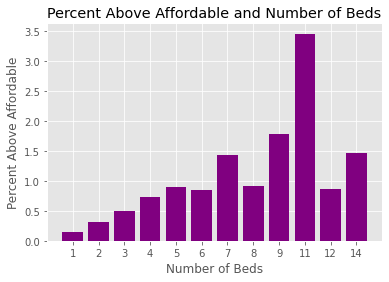

In [86]:
#GRAPH all propeerties # of Beds vs Affordability
%matplotlib inline
plt.style.use('ggplot')

x = number_of_beds
y = affordpercent_beds

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='purple')
plt.xlabel("Number of Beds")
plt.ylabel("Percent Above Affordable")
plt.title("Percent Above Affordable and Number of Beds")

plt.xticks(x_pos, x)

plt.show()

In [87]:
afford_beds = [
               sum(bed1["Affordable"]),sum(bed2["Affordable"]),
               sum(bed3["Affordable"]),sum(bed4["Affordable"]),
               sum(bed5["Affordable"]),sum(bed6["Affordable"]),
               sum(bed7["Affordable"]),sum(bed8["Affordable"]),
               sum(bed9["Affordable"]),sum(bed11["Affordable"]),
               sum(bed12["Affordable"]),sum(bed14["Affordable"])
]

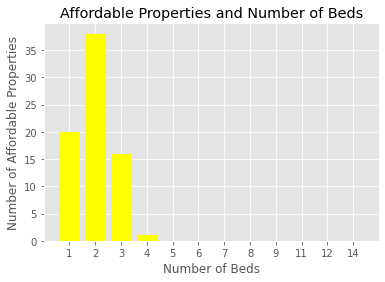

In [166]:
#GRAPH all propeerties # of Beds vs Affordability
%matplotlib inline
plt.style.use('ggplot')

x = number_of_beds
y = afford_beds

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='yellow')
plt.xlabel("Number of Beds")
plt.ylabel("Number of Affordable Properties")
plt.title("Affordable Properties and Number of Beds")

plt.xticks(x_pos, x)

plt.show()

## Number of Beds 

**Null Hypothesis**
- The Number of Beds WILL NOT have a statistically signifigant affect on the price or affordability of the property. 

**Alternative Hypothesis**
- The Number of Beds WILL have a statistically signifigant affect on the price or affordability of the property. 

**Conclusions**
- I reject the null hypothesis

## Number of Baths 

**Null Hypothesis**
- The Number of Baths WILL NOT have a statistically signifigant affect on the price or affordability of the property. 

**Alternative Hypothesis**
- The Number of Baths WILL have a statistically signifigant affect on the price or affordability of the property. 

In [88]:
#TTEST
stats.ttest_ind(cleaned_data["Baths"],cleaned_data["Price"],nan_policy="omit")

Ttest_indResult(statistic=-63.8817873425829, pvalue=0.0)

In [89]:
#Testing to see for each county if the # of baths affects the property price
print(stats.ttest_ind(whatcom["Baths"],whatcom["Price"],nan_policy="omit"))
print(stats.ttest_ind(island["Baths"],island["Price"],nan_policy="omit"))
print(stats.ttest_ind(skagit["Baths"],skagit["Price"],nan_policy="omit"))
print(stats.ttest_ind(snohomish["Baths"],snohomish["Price"],nan_policy="omit"))
print(stats.ttest_ind(king["Baths"],king["Price"],nan_policy="omit"))
print(stats.ttest_ind(pierce["Baths"],pierce["Price"],nan_policy="omit"))
print(stats.ttest_ind(kitsap["Baths"],kitsap["Price"],nan_policy="omit"))

Ttest_indResult(statistic=-23.810449766665535, pvalue=6.168318916054933e-90)
Ttest_indResult(statistic=-14.7527603063579, pvalue=7.750934374357328e-38)
Ttest_indResult(statistic=-17.48370929005409, pvalue=4.661817043087161e-49)
Ttest_indResult(statistic=-34.981344837231816, pvalue=8.199610303840599e-156)
Ttest_indResult(statistic=-33.46453329074655, pvalue=2.582825920629922e-162)
Ttest_indResult(statistic=-40.08280189078368, pvalue=1.2155823032861202e-189)
Ttest_indResult(statistic=-24.048324769796412, pvalue=2.3531281887170743e-100)


In [90]:
#Testing to see for each county if the # of baths affects affordability
print(stats.ttest_ind(whatcom["Baths"],whatcom["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(island["Baths"],island["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(skagit["Baths"],skagit["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(snohomish["Baths"],snohomish["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(king["Baths"],king["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(pierce["Baths"],pierce["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(kitsap["Baths"],kitsap["%Above_Below_Affordable"],nan_policy="omit"))

Ttest_indResult(statistic=22.367290568099612, pvalue=4.499852923675823e-82)
Ttest_indResult(statistic=11.448591802700065, pvalue=1.276857679822822e-25)
Ttest_indResult(statistic=17.069955158886888, pvalue=2.0574841985802615e-47)
Ttest_indResult(statistic=40.388238036263644, pvalue=4.8679536517264347e-185)
Ttest_indResult(statistic=35.02842544950029, pvalue=1.1368556654979719e-172)
Ttest_indResult(statistic=40.2281925487395, pvalue=1.8709032381827513e-190)
Ttest_indResult(statistic=35.80753727682154, pvalue=6.615479581681027e-179)


In [91]:
number_of_baths = cleaned_data["Baths"].unique().tolist()
number_of_baths.sort()

In [92]:
Bath1 = cleaned_data.where(cleaned_data["Beds"]==0.75).dropna()
Bath2 = cleaned_data.where(cleaned_data["Beds"]==1.0).dropna()
Bath3 = cleaned_data.where(cleaned_data["Beds"]==1.25).dropna()
Bath4 = cleaned_data.where(cleaned_data["Beds"]==1.5).dropna()
Bath5 = cleaned_data.where(cleaned_data["Beds"]==1.75).dropna()
Bath6 = cleaned_data.where(cleaned_data["Beds"]==2).dropna()
Bath7 = cleaned_data.where(cleaned_data["Beds"]==2.25).dropna()
Bath8 = cleaned_data.where(cleaned_data["Beds"]==2.5).dropna()
Bath9 = cleaned_data.where(cleaned_data["Beds"]==2.75).dropna()
Bath10 = cleaned_data.where(cleaned_data["Beds"]==3).dropna()
Bath11 = cleaned_data.where(cleaned_data["Beds"]==3.25).dropna()
Bath12 = cleaned_data.where(cleaned_data["Beds"]==3.5).dropna()
Bath13 = cleaned_data.where(cleaned_data["Beds"]==3.75).dropna()
Bath14 = cleaned_data.where(cleaned_data["Beds"]==4).dropna()
Bath15 = cleaned_data.where(cleaned_data["Beds"]==4.25).dropna()
Bath16 = cleaned_data.where(cleaned_data["Beds"]==4.5).dropna()
Bath17 = cleaned_data.where(cleaned_data["Beds"]==4.75).dropna()
Bath18 = cleaned_data.where(cleaned_data["Beds"]==5).dropna()
Bath19 = cleaned_data.where(cleaned_data["Beds"]==5.25).dropna()
Bath20 = cleaned_data.where(cleaned_data["Beds"]==5.5).dropna()
Bath21 = cleaned_data.where(cleaned_data["Beds"]==5.75).dropna()
Bath22 = cleaned_data.where(cleaned_data["Beds"]==6).dropna()
Bath23 = cleaned_data.where(cleaned_data["Beds"]==6.25).dropna()
Bath24 = cleaned_data.where(cleaned_data["Beds"]==6.75).dropna()
Bath25 = cleaned_data.where(cleaned_data["Beds"]==7).dropna()
Bath26 = cleaned_data.where(cleaned_data["Beds"]==7.5).dropna()
Bath27 = cleaned_data.where(cleaned_data["Beds"]==9).dropna()
Bath28 = cleaned_data.where(cleaned_data["Beds"]==10.5).dropna()

In [93]:
print(sum(Bath1["Baths"]))

0


In [94]:
Baths_Price = [
               Bath1["Price"].mean(),Bath2["Price"].mean(),Bath3["Price"].mean(),
               Bath4["Price"].mean(),Bath5["Price"].mean(),Bath6["Price"].mean(),
               Bath7["Price"].mean(),Bath8["Price"].mean(),Bath9["Price"].mean(),
               Bath10["Price"].mean(),Bath11["Price"].mean(),Bath12["Price"].mean(),
               Bath13["Price"].mean(),Bath14["Price"].mean(),Bath15["Price"].mean(),
               Bath16["Price"].mean(),Bath17["Price"].mean(),Bath18["Price"].mean(),
               Bath19["Price"].mean(),Bath20["Price"].mean(),Bath21["Price"].mean(),
               Bath22["Price"].mean(),Bath23["Price"].mean(),Bath24["Price"].mean(),
               Bath25["Price"].mean(),Bath26["Price"].mean(),Bath27["Price"].mean(),
               Bath28["Price"].mean()
               ]

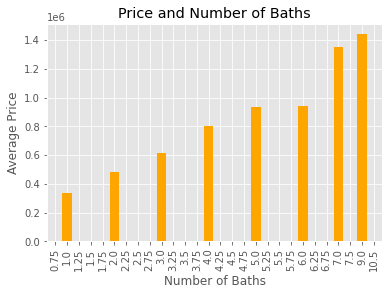

In [95]:
#GRAPH all properties # of Beds vs Price
%matplotlib inline
plt.style.use('ggplot')

x = number_of_baths
y = Baths_Price

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='orange')
plt.xlabel("Number of Baths")
plt.ylabel("Average Price")
plt.title("Price and Number of Baths")

plt.xticks(x_pos, x,rotation="vertical")

plt.show()

In [96]:
Baths_Afford = [
                Bath1["%Above_Below_Affordable"].mean(),Bath2["%Above_Below_Affordable"].mean(),
                Bath3["%Above_Below_Affordable"].mean(),Bath4["%Above_Below_Affordable"].mean(),
                Bath5["%Above_Below_Affordable"].mean(),Bath6["%Above_Below_Affordable"].mean(),
                Bath7["%Above_Below_Affordable"].mean(),Bath8["%Above_Below_Affordable"].mean(),
                Bath9["%Above_Below_Affordable"].mean(),Bath10["%Above_Below_Affordable"].mean(),
                Bath11["%Above_Below_Affordable"].mean(),Bath12["%Above_Below_Affordable"].mean(),
                Bath13["%Above_Below_Affordable"].mean(),Bath14["%Above_Below_Affordable"].mean(),
                Bath15["%Above_Below_Affordable"].mean(),Bath16["%Above_Below_Affordable"].mean(),
                Bath17["%Above_Below_Affordable"].mean(),Bath18["%Above_Below_Affordable"].mean(),
                Bath19["%Above_Below_Affordable"].mean(),Bath20["%Above_Below_Affordable"].mean(),
                Bath21["%Above_Below_Affordable"].mean(),Bath22["%Above_Below_Affordable"].mean(),
                Bath23["%Above_Below_Affordable"].mean(),Bath24["%Above_Below_Affordable"].mean(),
                Bath25["%Above_Below_Affordable"].mean(),Bath26["%Above_Below_Affordable"].mean(),
                Bath27["%Above_Below_Affordable"].mean(),Bath28["%Above_Below_Affordable"].mean(),
               ]

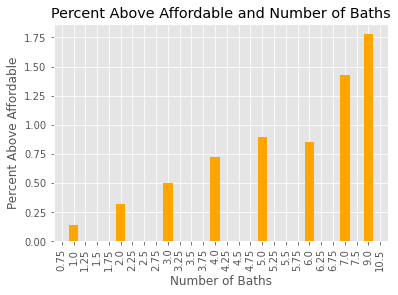

In [97]:
#GRAPH all properties # of Beds vs Affordability
%matplotlib inline
plt.style.use('ggplot')

x = number_of_baths
y = Baths_Afford

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='orange')
plt.xlabel("Number of Baths")
plt.ylabel("Percent Above Affordable")
plt.title("Percent Above Affordable and Number of Baths")

plt.xticks(x_pos, x,rotation="vertical")

plt.show()

In [167]:
Affordable_Baths = [
               sum(Bath1["Affordable"]),sum(Bath2["Affordable"]),sum(Bath3["Affordable"]),
               sum(Bath4["Affordable"]),sum(Bath5["Affordable"]),sum(Bath6["Affordable"]),
               sum(Bath7["Affordable"]),sum(Bath8["Affordable"]),sum(Bath9["Affordable"]),
               sum(Bath10["Affordable"]),sum(Bath11["Affordable"]),sum(Bath12["Affordable"]),
               sum(Bath13["Affordable"]),sum(Bath14["Affordable"]),sum(Bath15["Affordable"]),
               sum(Bath16["Affordable"]),sum(Bath17["Affordable"]),sum(Bath18["Affordable"]),
               sum(Bath19["Affordable"]),sum(Bath20["Affordable"]),sum(Bath21["Affordable"]),
               sum(Bath22["Affordable"]),sum(Bath23["Affordable"]),sum(Bath24["Affordable"]),
               sum(Bath25["Affordable"]),sum(Bath26["Affordable"]),sum(Bath27["Affordable"]),
               sum(Bath28["Affordable"])
               ]

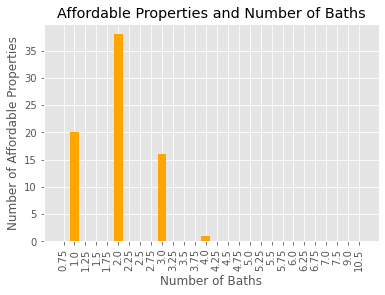

In [169]:
#GRAPH all properties # of Beds vs Affordability
%matplotlib inline
plt.style.use('ggplot')

x = number_of_baths
y = Affordable_Baths

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='orange')
plt.xlabel("Number of Baths")
plt.ylabel("Number of Affordable Properties")
plt.title("Affordable Properties and Number of Baths")

plt.xticks(x_pos, x,rotation="vertical")

plt.show()

## Number of Baths 

**Null Hypothesis**
- The Number of Baths WILL NOT have a statistically signifigant affect on the price or affordability of the property. 

**Alternative Hypothesis**
- The Number of Baths WILL have a statistically signifigant affect on the price or affordability of the property. 

**Conclusions**
- I reject the null hypothesis

## Ratio of Beds to Baths and Affordability

**Null Hypothesis**
- The ratio of beds to baths WILL NOT have a statistically signifigant importance to the affordability

**Alternative Hypothesis**
- The ratio of beds to baths WILL have a statistically signifigant importance to the affordability

In [98]:
hypothesis_beds_baths = cleaned_data[["Beds","Baths","Ratio_BedBath","Price","Affordable"]]

In [99]:
hypothesis_beds_baths.head(2)

,Beds,Baths,Ratio_BedBath,Price,Affordable
0,3,2.25,1.0,380000,False
1,2,1.00,2.0,300000,False


In [100]:
hypothesis_beds_baths["Affordable"] = hypothesis_beds_baths["Affordable"].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [101]:
affordable_condition = hypothesis_beds_baths["Affordable"]==1
affordable = hypothesis_beds_baths[affordable_condition]
print(affordable.shape)

(75, 5)


In [102]:
affordable_bedbath = [
                      round((sum(affordable["Ratio_BedBath"]==0)/75),2),
                      round((sum(affordable["Ratio_BedBath"]==1)/75),2),
                      round((sum(affordable["Ratio_BedBath"]==2)/75),2),
                      round((sum(affordable["Ratio_BedBath"]==3)/75),2),
                      round((sum(affordable["Ratio_BedBath"]==4)/75),2),
                      round((sum(affordable["Ratio_BedBath"]==5)/75),2)
]

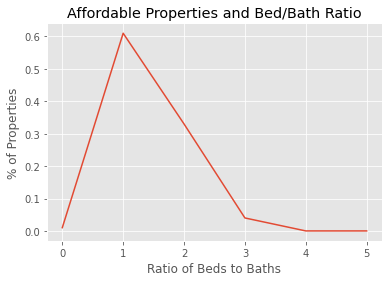

In [170]:
affordable_bedbath
x_axis = [0,1,2,3,4,5]
plt.plot(x_axis,affordable_bedbath)
plt.title('Affordable Properties and Bed/Bath Ratio')
plt.xlabel('Ratio of Beds to Baths')
plt.ylabel('% of Properties')
plt.show()

In [104]:
not_affordable_condition = hypothesis_beds_baths["Affordable"]==0
not_affordable = hypothesis_beds_baths[not_affordable_condition]
print(not_affordable.shape)

(2252, 5)


In [105]:
notaffordable_bedbath = [
                         round((sum(not_affordable["Ratio_BedBath"]==0)/2252),2),
                         round((sum(not_affordable["Ratio_BedBath"]==1)/2252),2),
                         round((sum(not_affordable["Ratio_BedBath"]==2)/2252),2),
                         round((sum(not_affordable["Ratio_BedBath"]==3)/2252),2),
                         round((sum(not_affordable["Ratio_BedBath"]==4)/2252),2),
                         round((sum(not_affordable["Ratio_BedBath"]==5)/2252),2)
]

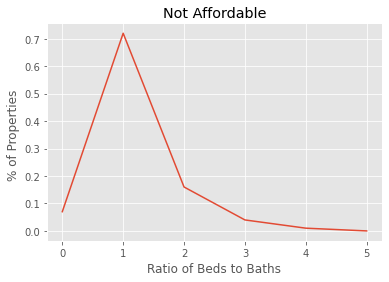

In [106]:
notaffordable_bedbath
x_axis = [0,1,2,3,4,5]
plt.plot(x_axis,notaffordable_bedbath)
plt.title('Not Affordable')
plt.xlabel('Ratio of Beds to Baths')
plt.ylabel('% of Properties ')
plt.show()

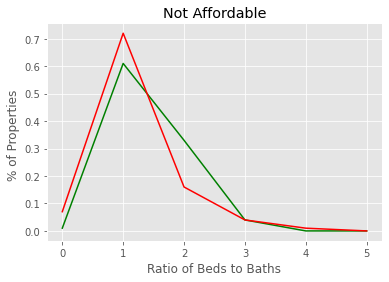

In [107]:
affordable_graph = [.01,.61,.33,.04,.0,.0]
not_affordable_graph = [.07,.72,.16,.04,.01,.0]
x_axis = [0,1,2,3,4,5]
plt.plot(x_axis,affordable_graph,color = "green")
plt.plot(x_axis,not_affordable_graph,color = "red")
plt.title('Not Affordable')
plt.xlabel('Ratio of Beds to Baths')
plt.ylabel('% of Properties ')
plt.show()

In [108]:
#T Test
#Bed bath Ratio vs Affordable
stats.ttest_ind(hypothesis_beds_baths["Ratio_BedBath"],hypothesis_beds_baths["Affordable"],nan_policy="omit")

Ttest_indResult(statistic=83.32433611766007, pvalue=0.0)

In [109]:
#Chi Squared
#Bed bath Ratio vs Affordable
g, p, dof, exptd = stats.chi2_contingency(pd.crosstab(hypothesis_beds_baths["Ratio_BedBath"],hypothesis_beds_baths["Affordable"]))
print(p)

0.0021405145703753243


## Ratio of Beds to Baths and Affordability 

**Null Hypothesis**
- The ratio of beds to baths WILL NOT have a statistically signifigant importance to the affordability

**Alternative Hypothesis**
- The ratio of beds to baths WILL have a statistically signifigant importance to the affordability

**Conclusions**
- I reject the null hypothesis. 

## Square Feet VS Affordability 

**Null Hypothesis**
- Property square footage WILL NOT have a statistically signifigant importance to the affordability of the property.

**Alternative Hypothesis**
- Property square footage WILL have a statistically signifigant importance to the affordability of the property.

In [110]:
#TTEST
stats.ttest_ind(cleaned_data["Square_Feet"],cleaned_data["Price"],nan_policy="omit")

Ttest_indResult(statistic=-63.67556689755124, pvalue=0.0)

In [111]:
#Testing to see for each county if the # of square feet affects the property price
print(stats.ttest_ind(whatcom["Square_Feet"],whatcom["Price"],nan_policy="omit"))
print(stats.ttest_ind(island["Square_Feet"],island["Price"],nan_policy="omit"))
print(stats.ttest_ind(skagit["Square_Feet"],skagit["Price"],nan_policy="omit"))
print(stats.ttest_ind(snohomish["Square_Feet"],snohomish["Price"],nan_policy="omit"))
print(stats.ttest_ind(king["Square_Feet"],king["Price"],nan_policy="omit"))
print(stats.ttest_ind(pierce["Square_Feet"],pierce["Price"],nan_policy="omit"))
print(stats.ttest_ind(kitsap["Square_Feet"],kitsap["Price"],nan_policy="omit"))

Ttest_indResult(statistic=-23.726400697704456, pvalue=1.7744958335384768e-89)
Ttest_indResult(statistic=-14.71089708652535, pvalue=1.1190780763426392e-37)
Ttest_indResult(statistic=-17.424820316179975, pvalue=7.994045722843637e-49)
Ttest_indResult(statistic=-34.86386447457153, pvalue=3.664993640068881e-155)
Ttest_indResult(statistic=-33.382541122653855, pvalue=9.045327047112022e-162)
Ttest_indResult(statistic=-39.91590577036675, pvalue=1.0448117657244607e-188)
Ttest_indResult(statistic=-23.96432765688648, pvalue=8.30594247122199e-100)


In [112]:
#Testing to see for each county if the # of square feet affects affordability
print(stats.ttest_ind(whatcom["Square_Feet"],whatcom["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(island["Square_Feet"],island["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(skagit["Square_Feet"],skagit["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(snohomish["Square_Feet"],snohomish["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(king["Square_Feet"],king["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(pierce["Square_Feet"],pierce["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(kitsap["Square_Feet"],kitsap["%Above_Below_Affordable"],nan_policy="omit"))

Ttest_indResult(statistic=31.13116503495322, pvalue=1.0867046884529359e-129)
Ttest_indResult(statistic=24.06871048174971, pvalue=1.926857098419046e-73)
Ttest_indResult(statistic=24.867743919420008, pvalue=5.436084467628367e-78)
Ttest_indResult(statistic=41.69900432597129, pvalue=6.678287959871945e-192)
Ttest_indResult(statistic=41.03552102559405, pvalue=9.442789828239086e-212)
Ttest_indResult(statistic=43.710001379228956, pvalue=1.3611306205666264e-209)
Ttest_indResult(statistic=48.1617170013549, pvalue=4.091847566650264e-258)


In [173]:
average_sqft = [
    whatcom["Square_Feet"].mean(),
    island["Square_Feet"].mean(),
    skagit["Square_Feet"].mean(),
    snohomish["Square_Feet"].mean(),
    king["Square_Feet"].mean(),
    pierce["Square_Feet"].mean(),
    kitsap["Square_Feet"].mean()
]

In [255]:
min_sqft = [
    whatcom["Square_Feet"].min(),
    island["Square_Feet"].min(),
    skagit["Square_Feet"].min(),
    snohomish["Square_Feet"].min(),
    king["Square_Feet"].min(),
    pierce["Square_Feet"].min(),
    kitsap["Square_Feet"].min()
    ]

In [256]:
max_sqft = [
    whatcom["Square_Feet"].max(),
    island["Square_Feet"].max(),
    skagit["Square_Feet"].max(),
    snohomish["Square_Feet"].max(),
    king["Square_Feet"].max(),
    pierce["Square_Feet"].max(),
    kitsap["Square_Feet"].max()
    ]

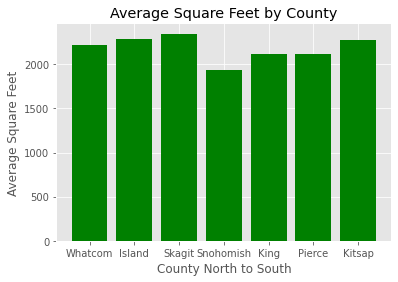

In [174]:
%matplotlib inline
plt.style.use('ggplot')

x = ["Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"]
y = average_sqft

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("County North to South")
plt.ylabel("Average Square Feet")
plt.title("Average Square Feet by County")

plt.xticks(x_pos, x)

plt.show()

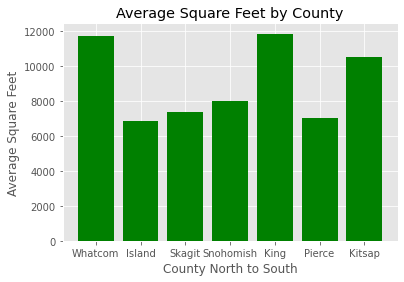

In [258]:
%matplotlib inline
plt.style.use('ggplot')

x = ["Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"]
ymin = min_sqft
ymax = max_sqft
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, ymin, color='green')
plt.bar(x_pos, ymax, color='green')
plt.xlabel("County North to South")
plt.ylabel("Average Square Feet")
plt.title("Average Square Feet by County")

plt.xticks(x_pos, x)

plt.show()

In [189]:
affordable_condition = cleaned_data["Affordable"]==1
square_feet = cleaned_data[affordable_condition]

(75, 28)

In [224]:
square_feet = square_feet.sort_values("Square_Feet")

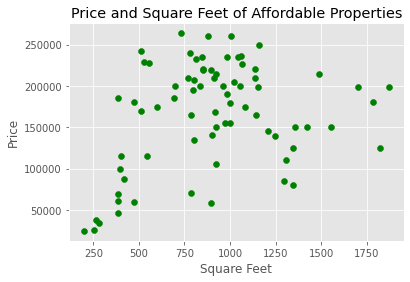

In [226]:
%matplotlib inline
plt.style.use('ggplot')

x = square_feet["Square_Feet"]
y = square_feet["Price"]

#x_pos = [i for i, _ in enumerate(x)]

plt.scatter(x, y, color='green')
plt.xlabel("Square Feet")
plt.ylabel("Price")
plt.title("Price and Square Feet of Affordable Properties")

#plt.xticks(x_pos, x)

plt.show()

## Square Feet VS Affordability 

**Null Hypothesis**
- Property square footage WILL NOT have a statistically signifigant importance to the affordability of the property.

**Alternative Hypothesis**
- Property square footage WILL have a statistically signifigant importance to the affordability of the property.

**Conclusions**
- I reject the null hypothesis

## $ Per Square Feet VS Affordability

**Null Hypothesis**

- $/Sq. Feet WILL NOT have a statistically signifigant importance to the affordability of the property.

**Alternative Hypothesis**

- $/Sq. Feet WILL have a statistically signifigant importance to the affordability of the property.

In [114]:
##TTEST
stats.ttest_ind(cleaned_data["$/Square_Feet"],cleaned_data["Price"],nan_policy="omit")

Ttest_indResult(statistic=-63.85185539723664, pvalue=0.0)

In [115]:
#Testing to see for each county if the $/Square_Feet affects the property price
print(stats.ttest_ind(whatcom["$/Square_Feet"],whatcom["Price"],nan_policy="omit"))
print(stats.ttest_ind(island["$/Square_Feet"],island["Price"],nan_policy="omit"))
print(stats.ttest_ind(skagit["$/Square_Feet"],skagit["Price"],nan_policy="omit"))
print(stats.ttest_ind(snohomish["$/Square_Feet"],snohomish["Price"],nan_policy="omit"))
print(stats.ttest_ind(king["$/Square_Feet"],king["Price"],nan_policy="omit"))
print(stats.ttest_ind(pierce["$/Square_Feet"],pierce["Price"],nan_policy="omit"))
print(stats.ttest_ind(kitsap["$/Square_Feet"],kitsap["Price"],nan_policy="omit"))

Ttest_indResult(statistic=-23.7996086132995, pvalue=7.069102781195934e-90)
Ttest_indResult(statistic=-14.746133745443101, pvalue=8.215003701018275e-38)
Ttest_indResult(statistic=-17.476217244198494, pvalue=4.9929138601172336e-49)
Ttest_indResult(statistic=-34.962854069135645, pvalue=1.0377773942888452e-155)
Ttest_indResult(statistic=-33.44831420448085, pvalue=3.309489284430281e-162)
Ttest_indResult(statistic=-40.06302476915104, pvalue=1.568268028519503e-189)
Ttest_indResult(statistic=-24.038111553737547, pvalue=2.7432842142891447e-100)


In [116]:
#Testing to see for each county if the $/Square_Feet affects affordability
print(stats.ttest_ind(whatcom["$/Square_Feet"],whatcom["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(island["$/Square_Feet"],island["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(skagit["$/Square_Feet"],skagit["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(snohomish["$/Square_Feet"],snohomish["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(king["$/Square_Feet"],king["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(pierce["$/Square_Feet"],pierce["%Above_Below_Affordable"],nan_policy="omit"))
print(stats.ttest_ind(kitsap["$/Square_Feet"],kitsap["%Above_Below_Affordable"],nan_policy="omit"))

Ttest_indResult(statistic=36.67785650793629, pvalue=1.134491008716685e-158)
Ttest_indResult(statistic=19.039742068263724, pvalue=2.244808945649447e-54)
Ttest_indResult(statistic=35.577904089759244, pvalue=1.1954159149945108e-115)
Ttest_indResult(statistic=59.66789025237594, pvalue=9.997042268345618e-277)
Ttest_indResult(statistic=58.7907748338214, pvalue=3.835835e-317)
Ttest_indResult(statistic=54.16558523402685, pvalue=3.7635880738848846e-263)
Ttest_indResult(statistic=47.36103938327297, pvalue=3.357342475875656e-253)


In [250]:
per_sqfoot = [
              whatcom["$/Square_Feet"].mean(),
              island["$/Square_Feet"].mean(),
              skagit["$/Square_Feet"].mean(),
              snohomish["$/Square_Feet"].mean(),
              king["$/Square_Feet"].mean(),
              pierce["$/Square_Feet"].mean(),
              kitsap["$/Square_Feet"].mean(),
]

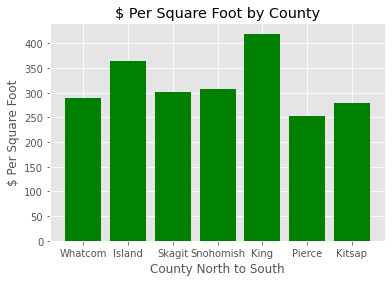

In [252]:
%matplotlib inline
plt.style.use('ggplot')

x = ["Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"]
y = per_sqfoot

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("County North to South")
plt.ylabel("$ Per Square Foot")
plt.title("$ Per Square Foot by County")

plt.xticks(x_pos, x)

plt.show()

## $ Per Square Feet VS Affordability

**Null Hypothesis**

- $/Sq. Feet WILL NOT have a statistically signifigant importance to the affordability of the property.

**Alternative Hypothesis**

- $/Sq. Feet WILL have a statistically signifigant importance to the affordability of the property.

**Conclusions**
- I reject the null hypothesis

## County VS Property Price

**Null Hypothesis**
- The county where the property is located DOES NOT have a statistically signifigant impact on the affordability of the property.

**Alternative Hypothesis**
- The county where the property is located DOES have a statistically signifigant impact on the affordability of the property.

In [118]:
hypothesis_county["Affordable"] = hypothesis_county["Affordable"].astype(int)
hypothesis_county["Affordable_Seattle_Mean_Income"] = hypothesis_county["Affordable_Seattle_Mean_Income"].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [119]:
county_affordable_properties = [ (round((sum(whatcom["Affordable"]==1)/75),2)),
                                round((sum(island["Affordable"]==1)/75),2),
                                round((sum(skagit["Affordable"]==1)/75),2),
                                round((sum(snohomish["Affordable"]==1)/75),2),
                                round((sum(king["Affordable"]==1)/75),2),
                                round((sum(pierce["Affordable"]==1)/75),2),
                                round((sum(kitsap["Affordable"]==1)/75),2)]

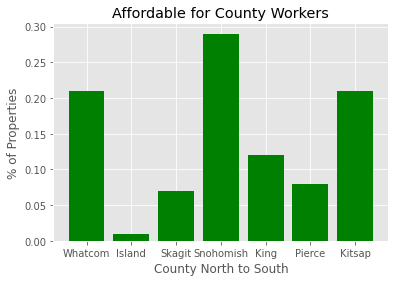

In [263]:
%matplotlib inline
plt.style.use('ggplot')

x = ["Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"]
y = county_affordable_properties

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("County North to South")
plt.ylabel("% of Properties")
plt.title("Affordable for County Workers")

plt.xticks(x_pos, x)

plt.show()

In [121]:
seattle_affordable_properties = [ (round((sum(whatcom["Affordable_Seattle_Mean_Income"]==1)/128),2)),
                                round((sum(island["Affordable_Seattle_Mean_Income"]==1)/128),2),
                                round((sum(skagit["Affordable_Seattle_Mean_Income"]==1)/128),2),
                                round((sum(snohomish["Affordable_Seattle_Mean_Income"]==1)/128),2),
                                round((sum(king["Affordable_Seattle_Mean_Income"]==1)/128),2),
                                round((sum(pierce["Affordable_Seattle_Mean_Income"]==1)/128),2),
                                round((sum(kitsap["Affordable_Seattle_Mean_Income"]==1)/128),2)]

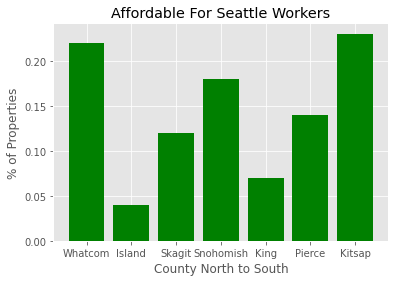

In [122]:
%matplotlib inline
plt.style.use('ggplot')

x = ["Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"]
y = seattle_affordable_properties

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("County North to South")
plt.ylabel("% of Properties")
plt.title("Affordable For Seattle Workers")

plt.xticks(x_pos, x)

plt.show()

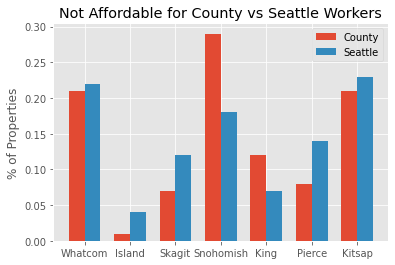

In [123]:
N = 7
county = county_affordable_properties
seattle = seattle_affordable_properties

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, county, width,label= "County")
plt.bar(ind + width, seattle, width,label= "Seattle")

plt.ylabel('% of Properties')
plt.title('Not Affordable for County vs Seattle Workers')

plt.xticks(ind + width / 2, ("Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"))
plt.legend(loc='best')
plt.show()

In [124]:
county_notaffordable_properties = [ (round((sum(whatcom["Affordable"]==0)/(len(whatcom))),2)),
                                round((sum(island["Affordable"]==0)/(len(island))),2),
                                round((sum(skagit["Affordable"]==0)/(len(skagit))),2),
                                round((sum(snohomish["Affordable"]==0)/(len(snohomish))),2),
                                round((sum(king["Affordable"]==0)/(len(king))),2),
                                round((sum(pierce["Affordable"]==0)/(len(pierce))),2),
                                round((sum(kitsap["Affordable"]==0)/(len(kitsap))),2)]

In [125]:
seattle_notaffordable_properties = [ (round((sum(whatcom["Affordable_Seattle_Mean_Income"]==0)/(len(whatcom))),2)),
                                round((sum(island["Affordable_Seattle_Mean_Income"]==0)/(len(island))),2),
                                round((sum(skagit["Affordable_Seattle_Mean_Income"]==0)/(len(skagit))),2),
                                round((sum(snohomish["Affordable_Seattle_Mean_Income"]==0)/(len(snohomish))),2),
                                round((sum(king["Affordable_Seattle_Mean_Income"]==0)/(len(king))),2),
                                round((sum(pierce["Affordable_Seattle_Mean_Income"]==0)/(len(pierce))),2),
                                round((sum(kitsap["Affordable_Seattle_Mean_Income"]==0)/(len(kitsap))),2)]

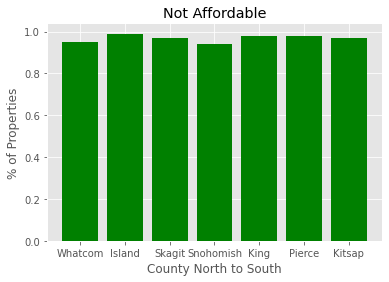

In [126]:
%matplotlib inline
plt.style.use('ggplot')

x = ["Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"]
y = county_notaffordable_properties

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("County North to South")
plt.ylabel("% of Properties")
plt.title("Not Affordable")

plt.xticks(x_pos, x)

plt.show()

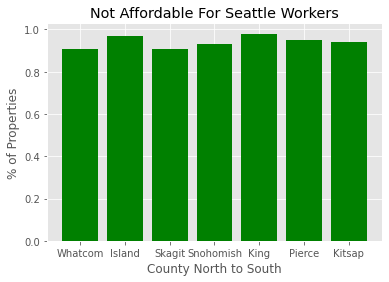

In [127]:
%matplotlib inline
plt.style.use('ggplot')

x = ["Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"]
y = seattle_notaffordable_properties

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel("County North to South")
plt.ylabel("% of Properties")
plt.title("Not Affordable For Seattle Workers")

plt.xticks(x_pos, x)

plt.show()

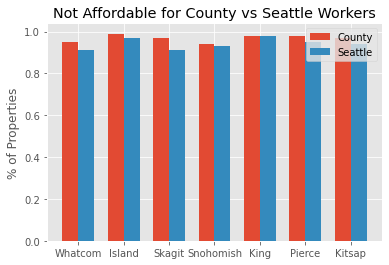

In [128]:
N = 7
county = county_notaffordable_properties
seattle = seattle_notaffordable_properties

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, county, width,label= "County")
plt.bar(ind + width, seattle, width,label= "Seattle")

plt.ylabel('% of Properties')
plt.title('Not Affordable for County vs Seattle Workers')

plt.xticks(ind + width / 2, ("Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"))
plt.legend(loc='best')
plt.show()

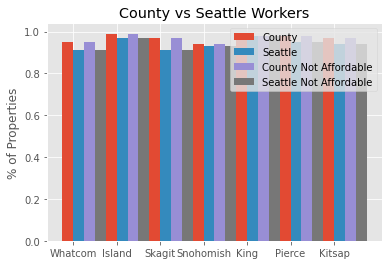

In [129]:
N = 7
county = county_notaffordable_properties
seattle = seattle_notaffordable_properties

county_na = county_notaffordable_properties
seattle_na = seattle_notaffordable_properties

ind = np.arange(N) 
width = 0.25       
plt.bar(ind, county, width,label= "County")
plt.bar(ind + width, seattle, width,label= "Seattle")
plt.bar(ind + width*2, county_na, width,label= "County Not Affordable")
plt.bar(ind + width*3, seattle_na, width,label= "Seattle Not Affordable")

plt.ylabel('% of Properties')
plt.title('County vs Seattle Workers')

plt.xticks(ind + width / 2, ("Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"))
plt.legend(loc='best')
plt.show()

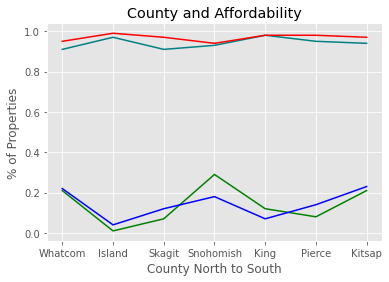

In [130]:
seattle_notaffordable_properties
county_notaffordable_properties
county_affordable_properties
seattle_affordable_properties
x_axis = ["Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"]
plt.plot(x_axis,county_affordable_properties,color= "green")
plt.plot(x_axis,seattle_notaffordable_properties,color = "teal")
plt.plot(x_axis,county_notaffordable_properties,color = "red")
plt.plot(x_axis,seattle_affordable_properties, color = "blue")
plt.title('County and Affordability')
plt.xlabel('County North to South')
plt.ylabel('% of Properties')
plt.show()

In [131]:
#T Test
#% Above Below Affordable for county workers vs seattle workers
#Affordable for county workers vs seattle workers
#Not Affordable for county workers vs seattle workers
stats.ttest_ind(hypothesis_county["County"],hypothesis_county["Affordable"],nan_policy="omit")

Ttest_indResult(statistic=74.97625495076291, pvalue=0.0)

In [132]:
stats.ttest_ind(hypothesis_county["County"],hypothesis_county["Affordable_Seattle_Mean_Income"],nan_policy="omit")

Ttest_indResult(statistic=74.17815756743612, pvalue=0.0)

In [133]:
#pd.crosstab(index = hypothesis_county["%Above_Below_Affordable"], columns = hypothesis_county["County"], normalize= "index")

In [134]:
g, p, dof, exptd = stats.chi2_contingency(pd.crosstab(hypothesis_county["County"],hypothesis_county["%Above_Below_Affordable"]))
print(p)

8.427492082444081e-47


In [135]:
g, p, dof, exptd = stats.chi2_contingency(pd.crosstab(hypothesis_county["County"],hypothesis_county["Seattle%AboveBelow_Affordable"]))
print(p)

1.8270386302398578e-36


## County VS Property Price

**Null Hypothesis**

The county where the property is located DOES NOT have a statistically signifigant impact on the affordability of the property.

**Alternative Hypothesis**

The county where the property is located DOES have a statistically signifigant impact on the affordability of the property.

**Conclusions**

I reject the null hypothesis. 

## Mean Income by County VS County Property Price

**Null Hypothesis** 
- The County Mean Income will NOT have an effect on the County mean property price

**Alternative Hypothesis**
- The County Mean Income will NOT have an effect on the County mean property price

In [136]:
county_mean_income = [
                  round(whatcom["Mean_Income"].mean(),2),
                  round(island["Mean_Income"].mean(),2),
                  round(skagit["Mean_Income"].mean(),2),
                  round(snohomish["Mean_Income"].mean(),2),
                  round(king["Mean_Income"].mean(),2),
                  round(pierce["Mean_Income"].mean(),2),
                  round(kitsap["Mean_Income"].mean(),2)
]

In [137]:
county_mean_ns = [
                  round(whatcom["Price"].mean(),2),
                  round(island["Price"].mean(),2),
                  round(skagit["Price"].mean(),2),
                  round(snohomish["Price"].mean(),2),
                  round(king["Price"].mean(),2),
                  round(pierce["Price"].mean(),2),
                  round(kitsap["Price"].mean(),2)
]

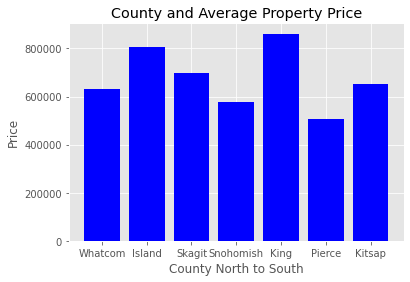

In [138]:
%matplotlib inline
plt.style.use('ggplot')

x = ["Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"]
y = county_mean_ns

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='blue')
plt.xlabel("County North to South")
plt.ylabel("Price")
plt.title("County and Average Property Price")

plt.xticks(x_pos, x)

plt.show()

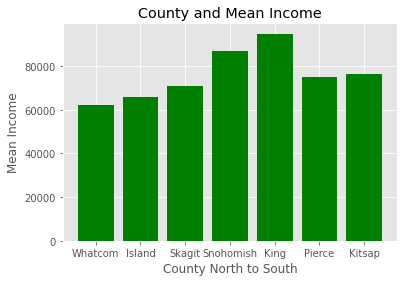

In [139]:
%matplotlib inline
plt.style.use('ggplot')

x = ["Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"]
y = county_mean_income

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.xlabel('County North to South')
plt.ylabel('Mean Income')
plt.title("County and Mean Income")

plt.xticks(x_pos, x)

plt.show()

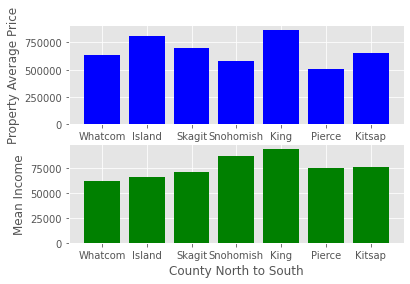

In [140]:
%matplotlib inline
plt.style.use('ggplot')

x = ["Whatcom","Island","Skagit","Snohomish","King","Pierce","Kitsap"]
x_pos = [i for i, _ in enumerate(x)]

county_mean_ns
county_mean_income

plt.subplot(2,1,1)
plt.bar(x_pos, county_mean_ns, color='blue')
plt.ylabel('Property Average Price')

plt.xticks(x_pos, x)

plt.subplot(2,1,2)

Mean_Income = plt.bar(x_pos, county_mean_income, color='green')
plt.xlabel('County North to South')
plt.ylabel('Mean Income')

plt.xticks(x_pos, x)

plt.show()

In [141]:
#Chi Squared 

## Mean Income by County VS County Property Price

**Null Hypothesis** 
- The County Mean Income will NOT have an effect on the County mean property price

**Alternative Hypothesis**
- The County Mean Income will NOT have an effect on the County mean property price

**Conclusions**
- .

# Visualizations

In [142]:
#mean income north to south

In [143]:
#Graph to show percentage mortgage, home maintenance, insurance, property tax is out of a total budget

In [144]:
visualization1 = cleaned_data[['Price','Mortgage','Property_Tax_Rate','%For_Home_Maintenance','Affordable']]

In [145]:
visualization1.head(2)

,Price,Mortgage,Property_Tax_Rate,%For_Home_Maintenance,Affordable
0,380000,1281.66,0.0101,0.04,False
1,300000,1011.84,0.0101,0.04,False


In [146]:
visualization1["Insurance"] = round((visualization1['Price']*.01)/12,2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [147]:
visualization1["Property_Tax"] = round((visualization1['Price']*visualization1['Property_Tax_Rate'])/12,2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [148]:
visualization1["Home_Maintenance"] = round((visualization1['Price']*visualization1['%For_Home_Maintenance'])/12,2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [149]:
visualization1["Cost_of_Home_Ownership"] = visualization1['Mortgage']+visualization1['Property_Tax']+visualization1['Insurance']+visualization1['Home_Maintenance']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [150]:
visualization1['Budget_to_Afford'] = round(visualization1['Cost_of_Home_Ownership']*(100/30),2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [151]:
visualization1 = visualization1.drop(['Property_Tax_Rate','%For_Home_Maintenance'],axis=1);

In [152]:
visualization1['Budget_Minus_Housing'] = visualization1['Budget_to_Afford']-visualization1['Cost_of_Home_Ownership']

In [153]:
visualization1.head(2)

,Price,Mortgage,Affordable,Insurance,Property_Tax,Home_Maintenance,Cost_of_Home_Ownership,Budget_to_Afford,Budget_Minus_Housing
0,380000,1281.66,False,316.67,319.83,1266.67,3184.83,10616.10,7431.27
1,300000,1011.84,False,250.00,252.50,1000.00,2514.34,8381.13,5866.79


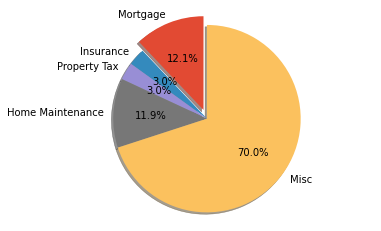

In [154]:
labels = 'Mortgage','Insurance','Property Tax','Home Maintenance','Misc'
sizes = [1281.66, 316.67, 319.83, 1266.67, 7431.27]
explode = (.1,0,0,0,0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show();

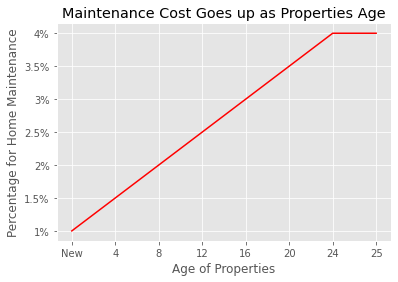

In [155]:
#as a home ages the % for home maintenance increases as well

y_axis = ['1%','1.5%','2%','2.5%','3%','3.5%','4%','4%']
x_axis = ["New",'4','8','12','16','20','24','25']

plt.plot(x_axis,y_axis,color="red")

plt.title('Maintenance Cost Goes up as Properties Age')
plt.xlabel('Age of Properties')
plt.ylabel('Percentage for Home Maintenance')

plt.show()

In [156]:
cleaned_data.head(2)

,MLS#,County,County_Name,City,City_Name,Zipcode,Lot_Size,Square_Feet,$/Square_Feet,Beds,Baths,Ratio_BedBath,Year_Built,Price,Property_Tax_Rate,Mean_Income,Age,%For_Home_Maintenance,Financed$,Mortgage,Total%_Cost_To_Own,Total$_Cost_To_Own,Income_Req_To_Afford,Affordable,Cost_to_Own%of_Mean_Income,%Above_Below_Affordable,Affordable_Seattle_Mean_Income,Seattle%AboveBelow_Affordable
0,1666770,4,Skagit,80,Mount Vernon,98273,4792,1540,247,3,2.25,1.0,1970,380000,0.0101,70955,50,0.04,304000,1281.66,0.0601,3184.83,127393.2,False,0.538623,0.24,False,0.10
1,1670882,4,Skagit,80,Mount Vernon,98273,4972,916,328,2,1.00,2.0,1970,300000,0.0101,70955,50,0.04,240000,1011.84,0.0601,2514.34,100573.6,False,0.425228,0.13,False,0.02


In [157]:
blogdata = cleaned_data[['Beds','Baths','Ratio_BedBath','Year_Built','Price','Mortgage','Affordable']]

In [158]:
blogdata.head(2)

,Beds,Baths,Ratio_BedBath,Year_Built,Price,Mortgage,Affordable
0,3,2.25,1.0,1970,380000,1281.66,False
1,2,1.00,2.0,1970,300000,1011.84,False


In [159]:
np.where(blogdata["Affordable"])[0]

array([ 150,  158,  161,  163,  165,  201,  207,  302,  303,  368,  369,
        409,  420,  450,  451,  452,  453,  459,  460,  498,  499,  511,
        523,  524,  527,  529,  530,  534,  544,  572,  585,  819,  820,
        821,  825,  826,  827,  828,  829,  830,  831,  839,  841,  842,
        857, 1087, 1089, 1145, 1146, 1238, 1243, 1271, 1311, 1401, 1641,
       1643, 1660, 1686, 1705, 1767, 1774, 1783, 1797, 1800, 1809, 1819,
       1868, 1945, 1948, 1949, 2012, 2104, 2145, 2178, 2267])

In [160]:
blogdata = blogdata[160:168]

In [161]:
blogdata = blogdata.reset_index();

In [162]:
blogdata = blogdata.drop("index",axis=1)

In [163]:
blogdata.columns = ['Beds', 'Baths', 'Ratio of Beds to Baths', 'Year Built', 'Price', 'Mortgage',
       'Affordable']

In [164]:
blogdata.head()

,Beds,Baths,Ratio of Beds to Baths,Year Built,Price,Mortgage,Affordable
0,3,2.0,1.0,1970,325000,1096.16,False
1,1,1.0,1.0,1970,180000,607.10,True
2,3,2.0,1.0,1970,450000,1517.76,False
3,3,1.5,2.0,1970,199000,671.19,True
4,3,2.0,1.0,1970,699000,2357.59,False


In [273]:
sum(cleaned_data["Affordable"]==1)*100/(sum(cleaned_data['Affordable']==0))

3.330373001776199

2252